# Lidar Validation - Field Data

#### Field data processing
This script will:<br>
A) Turn a csv file into a georeferenced shapefile<br>
B) Extract information from rasters to points<br>
C) Summarize stats<br>
D) plot points

In [1]:
import fiona
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
import os
import numpy as np
%matplotlib inline
import seaborn as sns

In [2]:
#define the watershed, phase, and year for plot titles

#either Englishman, Metro_Van, Tsitika, or Cruickshank
watershed = "Tsitika"
#either EGM, CRU, VAN, or TSI
wshed = "TSI"
# 1,2,3,4 or 5
phase = "5"
year = "21"
#cardinal, snow_course, 
plot_type = "cardinal"
#plot_type = "snow_course"


#change directory to watershed selected
path_parent = os.path.dirname(os.getcwd())
directory = os.path.join(path_parent, watershed)
#set directories for script
rasters = os.path.join(path_parent,watershed,"5_lidar_processing","datasets","rasters")
deliverables = os.path.join(path_parent, watershed, "5_lidar_processing", "deliverables", "field_validation","P0{}".format(phase))



In [3]:
#read in csv
os.chdir(directory)
field_data = pd.read_csv(os.path.join(directory, "4_field_data","plots","final","{}_P0{}.csv".format(wshed,phase)))
field_data = field_data[field_data["plot_type"]==plot_type]
display(field_data.head())

,Unnamed: 0,aco_flight_number,plot_datetime,study_area,plot_id,plot_type,cardinal,distance,multi_core,depth,...,northing,canopy_cover,canopy_density,canopy_height,slope,aspect_type,cover_type,elevation_band,swe_189,density_189
0,0,5,6/16/2021 12:58,Tsitika,ST1_A3,cardinal,E,2.5,NaN,108,...,5575992.665,NaN,NaN,NaN,15.0,Northeast,open,1500,NaN,NaN
1,1,5,6/17/2021 12:26,Tsitika,NaN,cardinal,E,2.5,NaN,177,...,5567171.211,NaN,NaN,NaN,NaN,0,open,1600,NaN,NaN
2,2,5,6/16/2021 14:55,Tsitika,ST1_OG7,cardinal,E,2.5,NaN,62,...,5576384.690,14.0,12.5,1.47,23.0,Northeast,sparse_trees,1300,NaN,NaN
3,3,5,6/17/2021 14:21,Tsitika,RR_A2,cardinal,E,2.5,NaN,139,...,5567377.415,NaN,NaN,NaN,30.0,Northwest,open,1500,NaN,NaN
4,4,5,6/17/2021 15:26,Tsitika,RR_OG3,cardinal,E,2.5,NaN,146,...,5567409.446,NaN,NaN,NaN,28.0,Northwest,open,1300,NaN,NaN


In [4]:
#extract the crs from the lidar dataset
os.chdir(rasters)
with rio.open("snowdepth_raw/{}_P0{}_{}_SD_raw.tif".format(wshed,phase,year)) as lidar_sd:
    CRS = lidar_sd.meta["crs"]
#convert the pandas df to gdf
pts = gpd.GeoDataFrame(field_data, geometry=gpd.points_from_xy(field_data.easting, field_data.northing), crs=CRS)

In [5]:
#extract eastings and northings from geodata frame
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pts.index = range(len(pts))
coords = [(x,y) for x,y in zip(pts.easting, pts.northing)]

#load in raster layers and extract the data
def read_extract_raster(pts,infile, variable):
    col_name = str(variable)
    variable = rio.open(infile, masked=True)
    #identify no data value
    nodataval = variable.nodatavals
    #extract the no data value from tuple
    nodataval=nodataval[0]
    #loop through the data points and sample the raster value
    pts[col_name]=[x[0] for x in variable.sample(coords)]
    #assign 0 to no data values of CHM
    if "canopy" in col_name:
        pts[col_name] = pts[col_name].map(lambda x: 0 if x == nodataval  else x)
    else:
    #assign NaN to the no data values for else
        pts[col_name] = pts[col_name].map(lambda x: np.nan if x == nodataval  else x)
    # return the dataframe
    return pts

#run function to extract raster data 
os.chdir(rasters)
pts = read_extract_raster(pts,"{}_1m_canopy_height.tif".format(wshed),"canopy_height")
pts = read_extract_raster(pts, "{}_1m_canopy_density.tif".format(wshed), "canopy_density")
pts = read_extract_raster(pts, "{}_1m_canopy_cover.tif".format(wshed), "canopy_cover")
pts = read_extract_raster(pts, "{}_aspect.tif".format(wshed), "aspect")
pts = read_extract_raster(pts, "{}_bare_earth.tif".format(wshed), "elevation")
pts = read_extract_raster(pts,"snowdepth_raw/{}_P0{}_{}_SD_raw.tif".format(wshed,phase,year), "SD_lidar")
pts = read_extract_raster(pts,"{}_slope.tif".format(wshed), "slope")

#format fields, create differnece in snow depth column
pts["SD_lidar"]  = round(pts["SD_lidar"]*100)
pts["field - lidar"] = pts["depth"]-pts["SD_lidar"]



def aspect(df, old_col, new_col):
    conditions_asp = [
        df[old_col] == -1,
        df[old_col] <= 22.5,
        df[old_col] <= 67.5,
        df[old_col] <= 112.5,
        df[old_col] <= 157.5,
        df[old_col] <= 202.5,
        df[old_col] <= 247.5,
        df[old_col] <= 292.5,
        df[old_col] <= 337.5,
        df[old_col] <= 360]

    values_asp = ["Flat", "North", "Northeast", "East", "Southeast", "South", "Southwest", "West", "Northwest", "North"]
    df[new_col] = np.select(conditions_asp, values_asp)

aspect(pts, "aspect", "aspect_cardinal")

def canopy_cover(df, old_col,new_col):
    conditions = [
        df[old_col] == 0,
        df[old_col] <=50, 
        df[old_col] <=100
    ]
    values = ["open", "sparse trees", "under canopy"]
    df[new_col]=np.select(conditions, values)
canopy_cover(pts, "canopy_cover", "cover_type")
display(pts.head())
#export data to csv
outfile = "{}_P0{}_{}_{}_lidar_data.csv".format(wshed,phase,year,plot_type)

pts.to_csv(os.path.join(deliverables, outfile),index=False)

,Unnamed: 0,aco_flight_number,plot_datetime,study_area,plot_id,plot_type,cardinal,distance,multi_core,depth,...,aspect_type,cover_type,elevation_band,swe_189,density_189,geometry,aspect,SD_lidar,field - lidar,aspect_cardinal
0,0,5,6/16/2021 12:58,Tsitika,ST1_A3,cardinal,E,2.500,NaN,108,...,Northeast,open,1500,NaN,NaN,POINT (688233.969 5575992.665),32.058,35.000,73.000,Northeast
1,1,5,6/17/2021 12:26,Tsitika,NaN,cardinal,E,2.500,NaN,177,...,0,open,1600,NaN,NaN,POINT (689976.306 5567171.211),0.000,NaN,NaN,North
2,2,5,6/16/2021 14:55,Tsitika,ST1_OG7,cardinal,E,2.500,NaN,62,...,Northeast,sparse trees,1300,NaN,NaN,POINT (687720.146 5576384.690),30.663,16.000,46.000,Northeast
3,3,5,6/17/2021 14:21,Tsitika,RR_A2,cardinal,E,2.500,NaN,139,...,Northwest,open,1500,NaN,NaN,POINT (689760.760 5567377.415),305.381,91.000,48.000,Northwest
4,4,5,6/17/2021 15:26,Tsitika,RR_OG3,cardinal,E,2.500,NaN,146,...,Northwest,open,1300,NaN,NaN,POINT (689374.805 5567409.446),316.241,108.000,38.000,Northwest


In [6]:
#convert gdf to df
df = pd.DataFrame(pts)

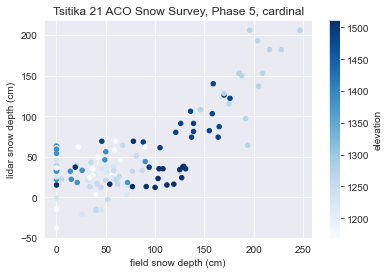

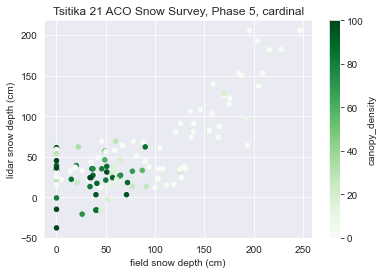

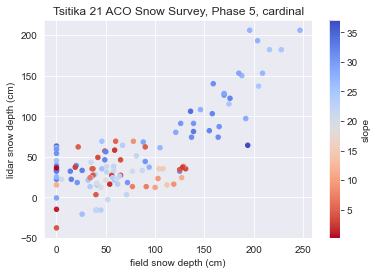

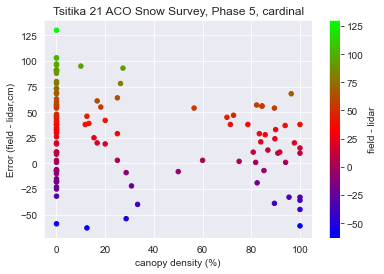

In [7]:
#generate a quick scatter plot of overall field data to summarize by raster elements
def plot_variable(watershed,year,phase,df,plot_type, x, y,color, cmap, xlabel, ylabel, outfolder):
    sns.set_style("darkgrid")
    fig, ax = plt.subplots()
    title = "{} {} ACO Snow Survey, Phase {}, {}".format(watershed,year,phase,plot_type)
    #fig = plt.figure(facecolor=(1, 1, 1))
    df.plot(kind="scatter", x=x,y=y,c=color, cmap=cmap, ax=ax)
    ax.set(xlabel=xlabel, ylabel=ylabel,title=title)
    output = "{}_P0{}_{}_{}_{}.jpg".format(wshed,phase,year,plot_type,color)
    graph_directory = os.path.join(outfolder,output)
    fig = ax.get_figure()
    fig.savefig(graph_directory, dpi=300)
    
#geneates individual plots, could combine into one figure here too. 
#Can mix and match variables within dataframe to generate other graphs
plot_variable(watershed,year,phase,df, plot_type, "depth", "SD_lidar","elevation", "Blues","field snow depth (cm)","lidar snow depth (cm)",
deliverables)
plot_variable(watershed,year,phase,df, plot_type, "depth", "SD_lidar","canopy_density", "Greens","field snow depth (cm)","lidar snow depth (cm)",
deliverables)
plot_variable(watershed,year,phase,df, plot_type,"depth", "SD_lidar", "slope", 'coolwarm_r',"field snow depth (cm)","lidar snow depth (cm)",
deliverables)
plot_variable(watershed,year,phase,df, plot_type,"canopy_density", "field - lidar","field - lidar", "brg", "canopy density (%)","Error (field - lidar,cm)",
deliverables)

In [8]:
#generate a summary table of results
def summary_stats(df,out_directory, wshed, phase,year,plot_type):
    sum = df.groupby(
        "plot_id").agg({
        "depth": ["mean", "std", "count"],
        "SD_lidar": ["mean", "std"],
        "field - lidar" : "mean",
        "slope": "mean",
        "canopy_cover": "mean",
        "canopy_height": "mean",
        "elevation" : "mean",
        "aspect": ["min", "max"]
    
        }).round(2)
    display(sum)
    output = "{}_P0{}_{}_{}_summaries.csv".format(wshed,phase,year,plot_type)
    sum.to_csv(os.path.join(out_directory, output))

summary_stats(df,deliverables, wshed, phase,year,plot_type)

depth              SD_lidar        field - lidar  slope  \
           mean    std count     mean    std          mean   mean   
plot_id                                                             
RR_A2   134.000 34.600    17   87.760 25.620        46.240 30.400   
RR_OG3  170.590 66.900    17  128.470 58.480        42.120 28.180   
RR_OG4   40.710 25.050    17   33.180 28.560         7.530  3.910   
ST1_A3   94.410 38.550    17   27.470 14.780        66.940  8.330   
ST1_OG7  52.220 19.820    18   19.670 22.370        32.560 21.360   
ST1_OG8  35.940 23.240    17   21.820 21.060        14.120 24.440   

        canopy_cover canopy_height elevation  aspect          
                mean          mean      mean     min     max  
plot_id                                                       
RR_A2          0.000         0.000  1486.540 288.590 313.200  
RR_OG3        15.460         1.850  1271.690 309.490 341.160  
RR_OG4        70.250        24.760  1169.720   6.830 352.750  
ST1_A3         4.320         0.340  1509.750   1.080 351.890  
ST1_OG7       46.280         9.230  1257.590  13.510  31.640  
ST1_OG8       54.840        13.210  1225.760  20.740  46.220

<Figure size 432x288 with 0 Axes>

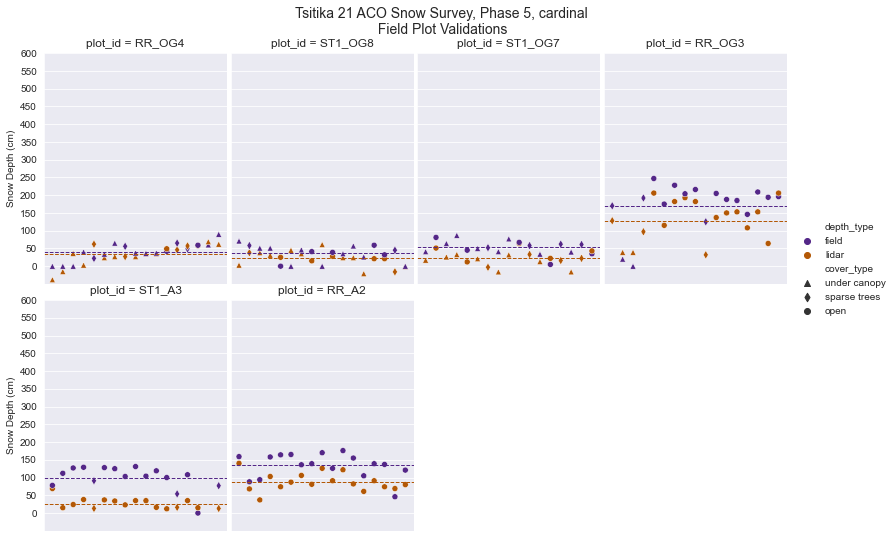

In [9]:
#graph the individual plots we want the y axis to be the same between phases
#graph code isn't pretty but she works!!

def field_plots_compare_graph(watershed,phase,year,df,plot_type,ymin,ymax,top_margin,outfolder):
    title = "{} {} ACO Snow Survey, Phase {}, {}".format(watershed, year, phase, plot_type)
    df = df.rename(columns={"depth" : "field", "SD_lidar" : "lidar"})
    #melt the dataframe to longform
    df=df.melt(id_vars=["plot_id", "cardinal", "distance", "cover_type"], value_vars=["field", "lidar"], var_name="depth_type", value_name="snow_depth")
    #create unique point value
    df["id"]= df["cardinal"]+df["distance"].astype(str)
    subset = df.columns.difference(['snow_depth'])
    #drop duplicate entries from subset less depth; some values have two depths that differ slightly from denisties vs probes
    df = df.sort_values("snow_depth", ascending=True).drop_duplicates(subset=subset, keep="last")
    #set up graph
    sns.set_style("darkgrid")
    sns.despine(left=True)
    #set font sizes
    SMALL_SIZE = 10
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 14
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    #Create facet grid
    g = sns.FacetGrid(df, col="plot_id", col_wrap=4, height = 4, aspect = .7)
    #g.set(ylim=(ymin, ymax), yticks=np.arange(500,50))
    g.set(ylim=(-50, 500), yticks=[0,50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600])
    
    #create plots and iterate over
    for col, col_name in enumerate(g.col_names):
        #print(col_name)
        ax = g.axes[col]
        filter = df[df["plot_id"] == col_name]
        groupby = filter.groupby(["depth_type"],as_index=False).snow_depth.mean()
        field_avg = groupby[groupby["depth_type"] == "field"]
        lidar_avg = groupby[groupby["depth_type"] == "lidar"]
        field_avg_pos = field_avg["snow_depth"].values[0]
        lidar_avg_pos = lidar_avg["snow_depth"].values[0]
        #print(field_avg_pos)
        #print(lidar_avg_pos)
        ax.axhline(field_avg_pos, color="#542788", ls="--", lw=1)
        ax.xaxis.grid(False)
        ax.axhline(lidar_avg_pos, color="#b35806", ls="--", lw=1)
    
    hue_order = ["field", "lidar"]
    # Field is purple, Lidar is orange
    palette = {"field" : "#542788", "lidar":"#b35806"}
    markers = {"open":"o", "sparse trees" : "d", "under canopy" : "^"}
    if plot_type == "snow_course":
        x="distance"
    else: 
        x="id"
        
    g = g.map_dataframe(sns.scatterplot, x, "snow_depth", hue="depth_type", style="cover_type", markers = markers, hue_order = hue_order, palette = palette)
    g = g.set(xticklabels=[], xlabel=None)
    g.set_ylabels(size = 10, label = "Snow Depth (cm)")
    g = g.add_legend()

    #add title and adjust margins, can customize top margin value in function
    plt.suptitle(title + "\n Field Plot Validations")
    plt.subplots_adjust(hspace=0.07, wspace=0.02, top=top_margin)
    
    #set export file name and directroy
    output = "{}_P0{}_{}_{}_validation_plots.jpg".format(wshed,phase,year,plot_type)
    graph_directory = os.path.join(outfolder, output)
    plt.savefig(graph_directory, dpi=300)
    
    plt.show()



    
field_plots_compare_graph(watershed,phase,year, df, plot_type, -50, 500,.9, deliverables)